# TVB-NEST: Bridging multiscale activity by co-simulation

## Step-by-step learn how to perform a co-simulation embedding spiking neural networks into large-scale brain networks using TVB.

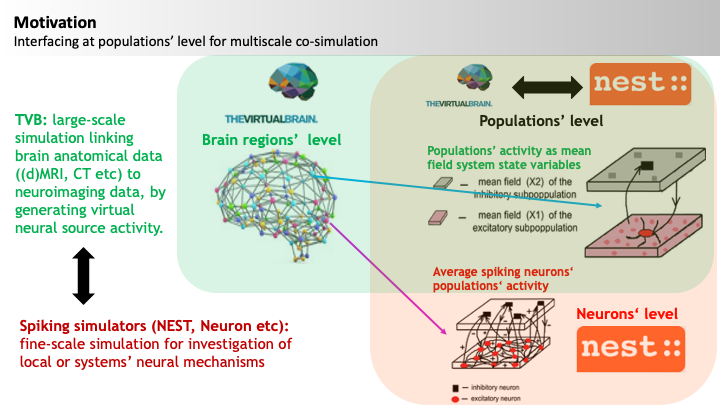

In [1]:
from IPython.core.display import Image, display
display(Image(filename='./ConceptGraph1.png',  width=1000, unconfined=False))

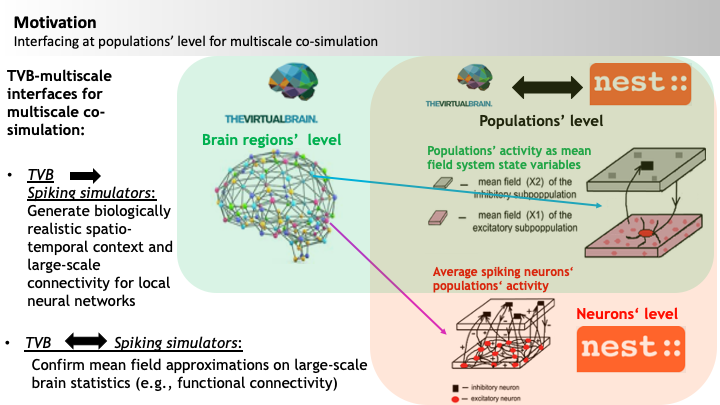

In [2]:
display(Image(filename='./ConceptGraph2.png',  width=1000, unconfined=False))

## tvb-multiscale toolbox:

### https://github.com/the-virtual-brain/tvb-multiscale

For questions use the git issue tracker, or write an e-mail to me: dionysios.perdikis@charite.de

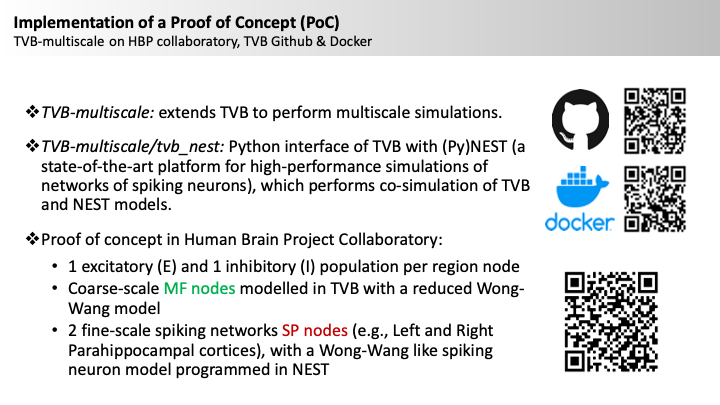

In [3]:
display(Image(filename='./Overview.png',  width=1000, unconfined=False))

# TVB - NEST co-simulation with Wilson & Cowan model

We demonstrate a multiscale simulation <br> of a Wilson & Cowan  model [1] <br> using TVB [1, 2] for brain region modelled at coarse scale, <br> and NEST [3] for regions modelled as <br> networks of spiking neural populations.

## Wilson & Cowan mean field model

See [1] for the equations (4.6a&b) of the model and for the parameters used here (column c in Table 11) for oscillatory regime.

## Spiking network model in NEST

For every neuron $i$ in region node $n$ modelled in NEST as a spiking network:


$ C_m{\dot{V}_{ni}}^m = - {I_{ni}}^L(t) - {I_{ni}}^{E}(t) - {I_{ni}}^{I}(t) - {I_{ni}}^{E,ext}(t) + I_e(t) $


## TVB to NEST coupling
TVB couples to NEST via instantaneous spike rate $ 1000 * N_E * E(t) $, 
where 1000 stands for the conversion from spikes/ms to spikes/sec. 

Spike generator NEST devices are used as TVB "proxy" nodes and generate spike trains 

$ \left[ \sum_k \delta(t-\tau_{n\prime n}-{t_j}^k) \right]_{j \in n\prime} $

Notice that all large-scale input is always scaled with the size of the excitatory population $ N_E $.

## NEST to TVB update

A NEST spike detector device is used to count spike for each time step, and convert it to an instant population mean rate that overrides the TVB state variables E and I:

$ E_n(t) =  \sum_j\left[ \sum_k \delta(t-\tau_n-{t_j}^k) \right]_{j \in E_n} / N_E $

$ I_n(t) =  \sum_j\left[ \sum_k \delta(t-\tau_n-{t_j}^k) \right]_{j \in I_n} / N_I $

## Simulator loop

### Simulating several (i.e., 10) NEST time steps for every 1 TVB time step for stable integration

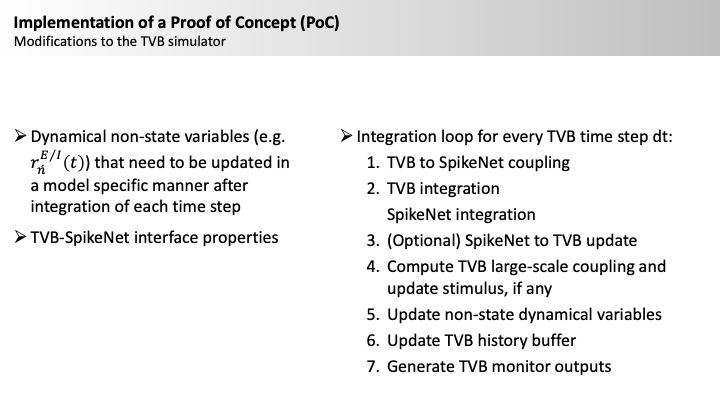

In [4]:
display(Image(filename='./simulator_loop.png',  width=10000, unconfined=False))

In [5]:
from collections import OrderedDict
import time
import numpy as np

from tvb.basic.profile import TvbProfile
TvbProfile.set_profile(TvbProfile.LIBRARY_PROFILE)

from tvb_nest.config import *
home_path = "/home/docker/packages/tvb-multiscale/docs/documented_example_notebook"
config = Config(output_base=os.path.join(home_path, "outputs_WilsonCowan"))
config.figures.SHOW_FLAG = True 
config.figures.SAVE_FLAG = True
config.figures.FIG_FORMAT = 'png'
config.figures.DEFAULT_SIZE= config.figures.NOTEBOOK_SIZE
FIGSIZE = config.figures.DEFAULT_SIZE

from tvb_multiscale.plot.plotter import Plotter
plotter = Plotter(config.figures)

# For interactive plotting:
# %matplotlib notebook  

# Otherwise:
%matplotlib inline 

/home/docker/packages/tvb-root/scientific_library/tvb/datatypes/surfaces.py:61: UserWarning: Geodesic distance module is unavailable; some functionality for surfaces will be unavailable.
  warnings.warn(msg)


2020-05-27 17:32:29,746 - WARNING - tvb.simulator.common - psutil module not available: no warnings will be issued when a
    simulation may require more memory than available


## 1. Load structural data <br> (minimally a TVB connectivity)  <br> & prepare TVB simulator  <br> (region mean field model, integrator, monitors etc)

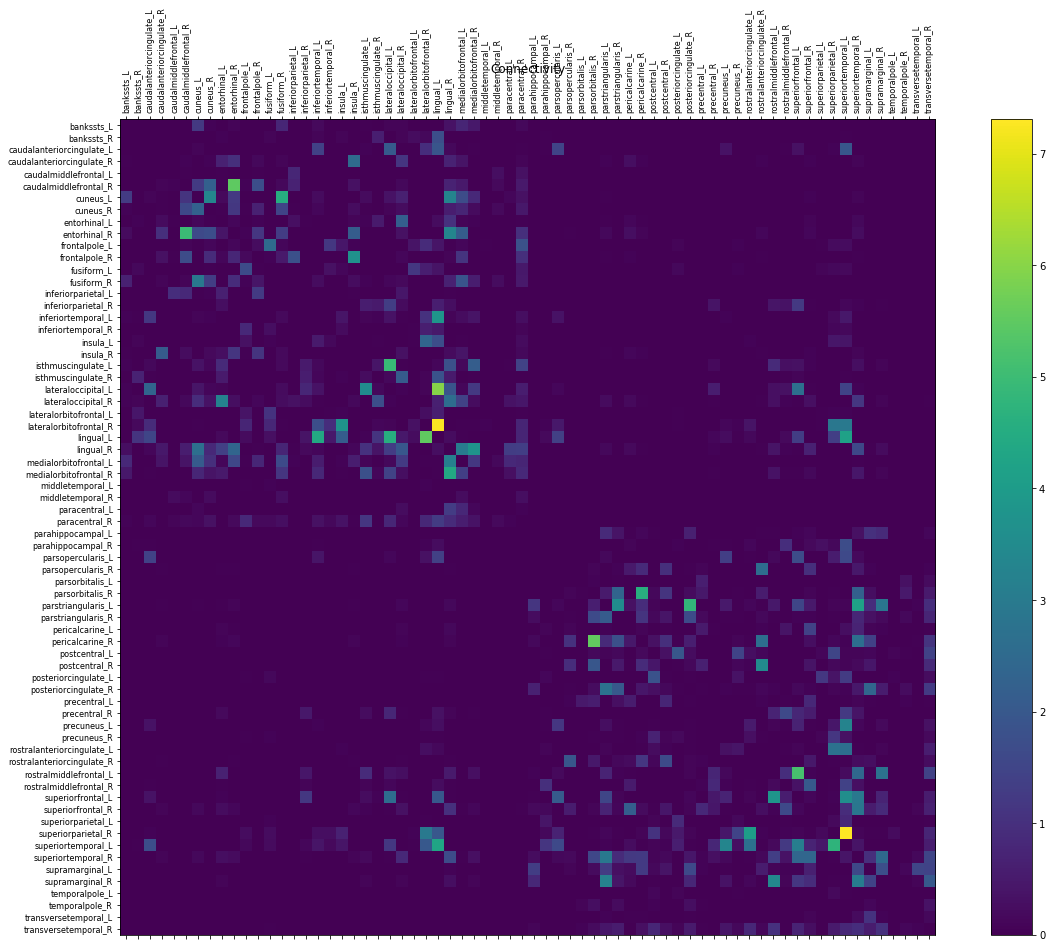

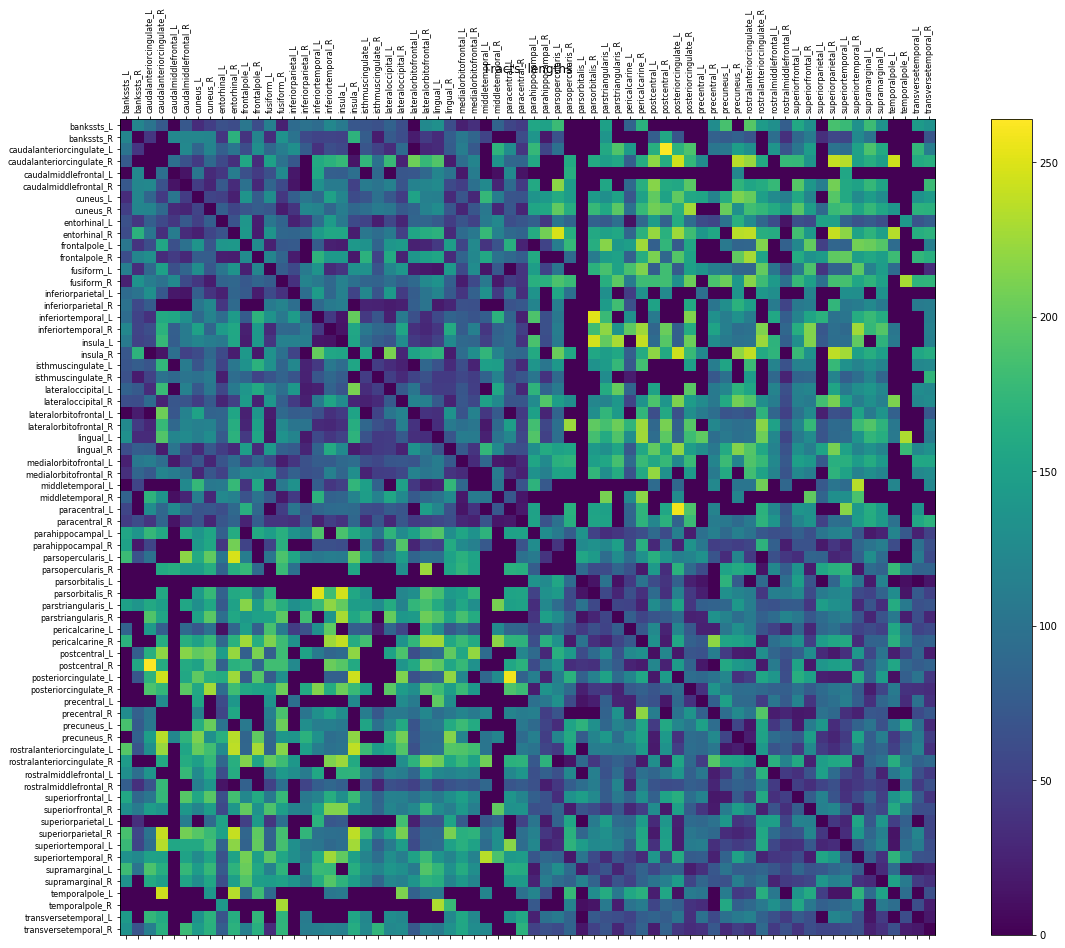

In [6]:
from tvb.simulator.models.wilson_cowan import WilsonCowan
from tvb_multiscale.tvb.simulator_builder import SimulatorBuilder


model_params = {
        "r_e": np.array([0.0]),
        "r_i": np.array([0.0]),
        "k_e": np.array([1.0]),
        "k_i": np.array([1.0]),
        "tau_e": np.array([10.0]),
        "tau_i": np.array([10.0]),
        "c_ee": np.array([10.0]),
        "c_ei": np.array([6.0]),
        "c_ie": np.array([10.0]),
        "c_ii": np.array([1.0]),
        "alpha_e": np.array([1.2]),
        "alpha_i": np.array([2.0]),
        "a_e": np.array([1.0]),
        "a_i": np.array([1.0]),
        "b_e": np.array([0.0]),
        "b_i": np.array([0.0]),
        "c_e": np.array([1.0]),
        "c_i": np.array([1.0]),
        "theta_e": np.array([2.0]),
        "theta_i": np.array([3.5]),
        "P": np.array([0.5]),
        "Q": np.array([0.0])
    }

# ----------------------1. Build a TVB simulator (model, integrator, monitors...)----------------------------------
simulator_builder = SimulatorBuilder()
simulator_builder.connectivity = config.DEFAULT_CONNECTIVITY_ZIP
simulator_builder.model = WilsonCowan

simulator = simulator_builder.build(**model_params)


# Optionally modify the default configuration:

# # ----------------------------------------------------------------------------------------------------------------
# # ----Uncomment below to modify the simulator by changing the default options:--------------------------------------
# # ----------------------------------------------------------------------------------------------------------------

# from tvb.datatypes.connectivity import Connectivity
# from tvb.simulator.simulator import Simulator
# from tvb.simulator.integrators import HeunStochastic
# from tvb.simulator.monitors import Raw  # , Bold, EEG
    
# # Load connectivity
# connectivity = Connectivity.from_file(config.DEFAULT_CONNECTIVITY_ZIP)
# # Normalize connectivity weights
# connectivity.weights = connectivity.scaled_weights(mode="region")
# connectivity.weights /= np.percentile(connectivity.weights, 95)
# connectivity.configure()

# # Create a TVB simulator and set all desired inputs
# # (connectivity, model, surface, stimuli etc)
# # We choose all defaults in this example
# simulator = Simulator()
# simulator.model = WilsonCowan(**model_params)

# simulator.connectivity = connectivity

# simulator.integrator = HeunStochastic()
# simulator.integrator.dt = 0.1
# simulator.integrator.noise.nsig = np.array([0.001])

# mon_raw = Raw(period=1.0)  # ms
# simulator.monitors = (mon_raw, )

# # ----------------------------------------------------------------------------------------------------------------
# # ----Uncomment below to modify the builder by changing the default options:--------------------------------------
# # ----------------------------------------------------------------------------------------------------------------

plotter.plot_tvb_connectivity(simulator.connectivity);

## 2. Build and connect the NEST network model <br> (networks of spiking neural populations for fine-scale <br>regions, stimulation devices, spike detectors etc)

In [7]:
# Select the regions for the fine scale modeling with NEST spiking networks
number_of_regions = simulator.connectivity.region_labels.shape[0]
nest_nodes_ids = []  # the indices of fine scale regions modeled with NEST
# We model parahippocampal cortices (left and right) with NEST
for id in range(number_of_regions):
    if simulator.connectivity.region_labels[id].find("hippo") > 0:
        nest_nodes_ids.append(id)
        
from tvb_nest.nest_models.builders.models.wilson_cowan import WilsonCowanBuilder

# Build a NEST network model with the corresponding builder
nest_model_builder = WilsonCowanBuilder(simulator, nest_nodes_ids, config=config)


N_E = int(nest_model_builder.population_order * nest_model_builder.scale_e)
N_I = int(nest_model_builder.population_order * nest_model_builder.scale_i)


# Using all default parameters for this example


# or...

# # ----------------------------------------------------------------------------------------------------------------
# # ----Uncomment below to modify the builder by changing the default options:--------------------------------------
# # ----------------------------------------------------------------------------------------------------------------

# population_neuron_model = "iaf_cond_alpha"

# nest_model_builder.population_order = 100

# nest_model_builder.scale_e = 1.0
# nest_model_builder.scale_i = 1.0

# N_E = int(nest_model_builder.population_order * nest_model_builder.scale_e)
# N_I = int(nest_model_builder.population_order * nest_model_builder.scale_i)

# nest_model_builder.global_coupling_scaling = nest_model_builder.tvb_simulator.coupling.a[0].item() 

# # When any of the properties model, params and scale below depends on regions,
# # set a handle to a function with
# # arguments (region_index=None) returning the corresponding property

# w_ee = nest_model_builder.tvb_model.c_ee[0].item()
# w_ei = nest_model_builder.tvb_model.c_ei[0].item()
# w_ie = nest_model_builder.tvb_model.c_ie[0].item()
# w_ii = nest_model_builder.tvb_model.c_ii[0].item()


# # Populations' configurations
# # When any of the properties model, params and scale below depends on regions,
# # set a handle to a function with
# # arguments (region_index=None) returning the corresponding property
# nest_model_builder.populations = [
#     {"label": "E", "model": population_neuron_model,
#       "params": {}, "nodes": None,  # None means "all"
#      "scale": nest_model_builder.scale_e},
#     {"label": "I", "model": population_neuron_model,
#      "params": {}, "nodes": None,  # None means "all"
#      "scale": nest_model_builder.scale_i}
#   ]

# # Within region-node connections
# # When any of the properties model, conn_spec, weight, delay, receptor_type below
# # set a handle to a function with
# # arguments (region_index=None) returning the corresponding property

# synapse_model = "static_synapse"
# conn_spec = {"autapses": True, 'multapses': True, 'rule': "all_to_all",
#              "indegree": None, "outdegree": None, "N": None, "p": 0.1}


# within_node_delay = {"distribution": "uniform", 
#                      "low": np.minimum(nest_model_builder.nest_instance.GetKernelStatus("min_delay"), 
#                                        nest_model_builder.default_populations_connection["delay"]), 
#                      "high": np.maximum(nest_model_builder.tvb_dt, 
#                                         2*nest_model_builder.default_populations_connection["delay"])}

# nest_model_builder.populations_connections = [
#      #              ->
#     {"source": "E", "target": "E",  # E -> E This is a self-connection for population "E"
#      "model": synapse_model, "conn_spec": conn_spec,
#      "weight": {"distribution": "normal", "mu": w_ee, "sigma": 0.1*w_ee},
#      "delay": within_node_delay,
#      "receptor_type": 0, "nodes": None},  # None means apply to all
#     {"source": "E", "target": "I",  # E -> I
#      "model": synapse_model, "conn_spec": conn_spec,
#      "weight": {"distribution": "normal", "mu": w_ei, "sigma": 0.1*w_ei},
#      "delay": within_node_delay,
#      "receptor_type": 0, "nodes": None},  # None means apply to all
#     {"source": "I", "target": "E",  # I -> E
#      "model": synapse_model,
#      "conn_spec": conn_spec, "weight": {"distribution": "normal", "mu": -w_ie, "sigma": 0.1*w_ie},
#      "delay": within_node_delay,
#      "receptor_type": 0, "nodes": None},  # None means apply to all
#     {"source": "I", "target": "I",  # I -> I This is a self-connection for population "I"
#      "model": synapse_model, "conn_spec": conn_spec,
#      "weight": {"distribution": "normal", "mu": -w_ii, "sigma": 0.1*w_ii},
#      "delay": within_node_delay,
#      "receptor_type": 0, "nodes": None}  # None means apply to all
#     ]


# # Among/Between region-node connections
# # Given that only the AMPA population of one region-node couples to
# # all populations of another region-node,
# # we need only one connection type
        
# # When any of the properties model, conn_spec, weight, delay, receptor_type below
# # depends on regions, set a handle to a function with
# # arguments (source_region_index=None, target_region_index=None)

# from tvb_multiscale.spiking_models.builders.templates \
#     import random_normal_tvb_weight, random_uniform_tvb_delay
    
# # Total excitatory spikes of one region node will be distributed to
# nest_model_builder.nodes_connections = [
#     #              ->
#     {"source": "E", "target": ["E"],
#      "model": synapse_model, "conn_spec": conn_spec,
#      "weight": lambda source_node, target_node: 
#                  random_normal_tvb_weight(source_node, target_node, nest_model_builder.tvb_weights, 
#                                           scale=nest_model_builder.global_coupling_scaling, sigma=0.1),
#      "delay": lambda source_node, target_node: \
#                  random_uniform_tvb_delay(source_node, target_node, nest_model_builder.tvb_delays, 
#                                           low=nest_model_builder.tvb_dt, 
#                                           high=2*nest_model_builder.tvb_dt, 
#                                           sigma=0.1),  
#      "receptor_type": 0,
#      "source_nodes": None, "target_nodes": None}  # None means apply to all
#     ]

# # Creating  devices to be able to observe NEST activity:

# nest_model_builder.output_devices = []

# connections = OrderedDict({})
# #          label <- target population
# connections["E"] = "E"
# connections["I"] = "I"
# nest_model_builder.output_devices.append(
#     {"model": "spike_detector", "params": {},
#      "connections": connections, "nodes": None})  # None means apply to "all"

# # Labels have to be different

# connections = OrderedDict({})
# #               label    <- target population
# connections["Excitatory"] = "E"
# connections["Inhibitory"] = "I"
# params = {"withtime": True, "withgid": True, 'record_from': ["V_m"], "interval": 1.0}
# nest_model_builder.output_devices.append(
#     {"model": "multimeter", "params": params,
#      "connections": connections, "nodes": None})  # None means apply to all
    

# # Create a spike stimulus input device
# nest_model_builder.input_devices = [
#     {"model": "poisson_generator",
#      "params": {"rate": 6400.0, "origin": 0.0, "start": 0.1},  # "stop": 100.0
#      "connections": {"Stimulus": ["E"]}, 
#      "nodes": None,         # None means apply to all
#      "weights": {"distribution": "normal", "mu": 1.0, "sigma": 0.1}, 
#      "delays": {"distribution": "uniform", 
#                 "low": nest_model_builder.tvb_dt, 
#                 "high": 2*nest_model_builder.tvb_dt},
#      "receptor_type": 0}
#                                   ]  #

# # ----------------------------------------------------------------------------------------------------------------
# # ----------------------------------------------------------------------------------------------------------------
# # ----------------------------------------------------------------------------------------------------------------

nest_network = nest_model_builder.build_spiking_network()


2020-05-27 17:32:36,089 - INFO - tvb_nest.nest_models.builders.base - Loading a NEST instance...
2020-05-27 17:32:36,089 - INFO - tvb_nest.nest_models.builders.base - Loading a NEST instance...
2020-05-27 17:32:36,091 - INFO - tvb_nest.nest_models.builders.base - NEST_INSTALL_DIR: /home/docker/env/neurosci/nest_build
2020-05-27 17:32:36,091 - INFO - tvb_nest.nest_models.builders.base - NEST_INSTALL_DIR: /home/docker/env/neurosci/nest_build
2020-05-27 17:32:36,094 - INFO - tvb_nest.nest_models.builders.base - NEST_DATA_DIR: /home/docker/env/neurosci/nest_build/share/nest
2020-05-27 17:32:36,094 - INFO - tvb_nest.nest_models.builders.base - NEST_DATA_DIR: /home/docker/env/neurosci/nest_build/share/nest
2020-05-27 17:32:36,096 - INFO - tvb_nest.nest_models.builders.base - NEST_DOC_DIR: /home/docker/env/neurosci/nest_build/share/doc/nest
2020-05-27 17:32:36,096 - INFO - tvb_nest.nest_models.builders.base - NEST_DOC_DIR: /home/docker/env/neurosci/nest_build/share/doc/nest
2020-05-27 17:32:3

2020-05-27 17:32:36,231 - WARNING - tvb_nest.nest_models.builders.base - Within Spiking nodes delay {'distribution': 'uniform', 'low': 0.05, 'high': 0.1} is not smaller than half the TVB integration time step 0.100000!
2020-05-27 17:32:36,231 - WARNING - tvb_nest.nest_models.builders.base - Within Spiking nodes delay {'distribution': 'uniform', 'low': 0.05, 'high': 0.1} is not smaller than half the TVB integration time step 0.100000!
2020-05-27 17:32:36,240 - WARNING - tvb_nest.nest_models.builders.base - Within Spiking nodes delay {'distribution': 'uniform', 'low': 0.05, 'high': 0.1} is not smaller than half the TVB integration time step 0.100000!
2020-05-27 17:32:36,240 - WARNING - tvb_nest.nest_models.builders.base - Within Spiking nodes delay {'distribution': 'uniform', 'low': 0.05, 'high': 0.1} is not smaller than half the TVB integration time step 0.100000!
2020-05-27 17:32:36,247 - WARNING - tvb_nest.nest_models.builders.base - Within Spiking nodes delay {'distribution': 'unifor

## 3. Build the TVB-NEST interface

In [8]:
from tvb_nest.interfaces.builders.models.wilson_cowan import \
    WilsonCowanBuilder as InterfaceWilsonCowanBuilder

# Build a TVB-NEST interface with all the appropriate connections between the
# TVB and NEST modelled regions
tvb_nest_builder = \
    InterfaceWilsonCowanBuilder(simulator, nest_network, nest_nodes_ids, 
                                exclusive_nodes=True, N_E=N_E, N_I=N_I)

tvb_to_nest_mode="rate"
nest_to_tvb=True

# Using all default parameters for this example

# or...


# # ----------------------------------------------------------------------------------------------------------------
# # ----Uncomment below to modify the builder by changing the default options:--------------------------------------
# # ----------------------------------------------------------------------------------------------------------------

# from tvb_multiscale.spiking_models.builders.templates \
#     import random_normal_tvb_weight, random_uniform_tvb_delay


# # TVB -> NEST


# # --------For spike transmission from TVB to NEST devices acting as TVB proxy nodes with TVB delays:--------


# if tvb_to_nest_mode == "rate":
#     # Mean spike rates are applied in parallel to all target neurons

#     tvb_nest_builder.tvb_to_nest_interfaces = [
#         {"model": "inhomogeneous_poisson_generator",
#          "params": {"allow_offgrid_times": False},
#     # # ---------Properties potentially set as function handles with args (nest_node_id=None)-------------------------
#          "interface_weights": 1.0 * N_E, 
#     # Applied outside NEST for each interface device
#     # -------Properties potentially set as function handles with args (tvb_node_id=None, nest_node_id=None)-----------
#         "weights": lambda tvb_node_id, nest_node_id: \
#                             random_normal_tvb_weight(tvb_node_id, nest_node_id, tvb_nest_builder.tvb_weights, 
#                                                      scale=tvb_nest_builder.global_coupling_scaling, sigma=0.1),
#         "delays": lambda tvb_node_id, nest_node_id: \
#                         random_uniform_tvb_delay(tvb_node_id, nest_node_id, tvb_nest_builder.tvb_delays,
#                                                  low=tvb_nest_builder.tvb_dt, 
#                                                  high=2*tvb_nest_builder.tvb_dt, 
#                                                  sigma=0.1),
#         "receptor_type": 0,
#         # --------------------------------------------------------------------------------------------------------------
#         #             TVB sv -> NEST population
#         "connections": {"E": ["E"]},
#         "source_nodes": None, "target_nodes": None}]  # None means all here

    
# if nest_to_tvb:
#     # NEST -> TVB:
#     # Use S_e and S_i instead of r_e and r_i
#     # for transmitting to the TVB state variables directly
#     connections = OrderedDict()
#     #            TVB <- NEST
#     connections["E"] = ["E"]
#     connections["I"] = ["I"]
#     tvb_nest_builder.nest_to_tvb_interfaces = [
#         {"model": "spike_detector", "params": {},
#     # ------------------Properties potentially set as function handles with args (nest_node_id=None)--------------------
#          "weights": 1.0, "delays": 0.0,
#     # -----------------------------------------------------------------------------------------------------------------
#          "connections": connections, "nodes": None}]  # None means all here

    
# # WilsonCowan model state variables are bounded in [0, 1],
# # and have to be converted in Hz as poisson_generator assumes in NEST:
# tvb_nest_builder.w_tvb_to_spike_rate = 1000.0
# # We return from a NEST spike_detector the ratio number_of_population_spikes / number_of_population_neurons
# # for every TVB time step, which is already a quantity in the range [0.0, 1.0],
# # as long as a neuron cannot fire twice during a TVB time step, i.e.,
# # as long as the TVB time step (usually 0.001 to 0.1 ms)
# # is smaller than the neurons' refractory time, t_ref (usually 1-2 ms)
# tvb_nest_builder.w_spikes_to_tvb = 1.0

# # ----------------------------------------------------------------------------------------------------------------
# # ----------------------------------------------------------------------------------------------------------------
# # ----------------------------------------------------------------------------------------------------------------

tvb_nest_model = tvb_nest_builder.build_interface(tvb_to_nest_mode=tvb_to_nest_mode, nest_to_tvb=nest_to_tvb)

2020-05-27 17:32:37,407 - INFO - tvb_multiscale.interfaces.base - <class 'tvb_nest.interfaces.models.WilsonCowan'> created!
2020-05-27 17:32:37,407 - INFO - tvb_multiscale.interfaces.base - <class 'tvb_nest.interfaces.models.WilsonCowan'> created!
2020-05-27 17:32:37,410 - INFO - tvb_nest.interfaces.models - <class 'tvb_nest.interfaces.models.WilsonCowan'> created!
2020-05-27 17:32:37,410 - INFO - tvb_nest.interfaces.models - <class 'tvb_nest.interfaces.models.WilsonCowan'> created!
2020-05-27 17:32:37,419 - INFO - tvb_multiscale.spiking_models.devices - <class 'tvb_multiscale.spiking_models.devices.DeviceSet'> of model inhomogeneous_poisson_generator for E created!
2020-05-27 17:32:37,419 - INFO - tvb_multiscale.spiking_models.devices - <class 'tvb_multiscale.spiking_models.devices.DeviceSet'> of model inhomogeneous_poisson_generator for E created!
2020-05-27 17:32:37,698 - INFO - tvb_multiscale.spiking_models.devices - <class 'tvb_nest.interfaces.tvb_to_nest_devices_interfaces.TVBtoN

## 4. Configure simulator, simulate, gather results

In [9]:
# Configure the simulator with the TVB-NEST interface...
simulator.configure(tvb_spikeNet_interface=tvb_nest_model)
# ...and simulate!
t = time.time()
results = simulator.run(simulation_length=1100.0)
# Integrate NEST one more NEST time step so that multimeters get the last time point
# unless you plan to continue simulation later
simulator.run_spiking_simulator(simulator.tvb_spikeNet_interface.nest_instance.GetKernelStatus("resolution"))
print("\nSimulated in %f secs!" % (time.time() - t))

...100.0% done in 426.5 sec
Simulated in 426.553170 secs!


In [10]:
# Clean-up NEST simulation
simulator.tvb_spikeNet_interface.nest_instance.Cleanup()

## 5. Plot results and write them to HDF5 files

In [11]:
# from tvb_multiscale.examples.plot_write_results import plot_write_results
# plot_write_results(results, simulator, [N_E, N_I], transient=10.0, tvb_state_variable_type_label="State Variables",
#                    tvb_state_variables_labels=simulator.model.variables_of_interest, plotter=plotter, config=config)

In [12]:
# If you want to see what the function above does, take the steps, one by one
try:
    # We need framework_tvb for writing and reading from HDF5 files
    from tvb_multiscale.io.h5_writer import H5Writer
    writer = H5Writer()
except:
    writer = False
    
from tvb.contrib.scripts.datatypes.time_series import TimeSeriesRegion
from tvb.contrib.scripts.datatypes.time_series_xarray import TimeSeriesRegion as TimeSeriesXarray

# Put the results in a Timeseries instance
from tvb.contrib.scripts.datatypes.time_series import TimeSeriesRegion

source_ts = TimeSeriesXarray(  # substitute with TimeSeriesRegion fot TVB like functionality
        data=results[0][1], time=results[0][0],
        connectivity=simulator.connectivity,
        labels_ordering=["Time", "State Variable", "Region", "Neurons"],
        labels_dimensions={"State Variable": list(simulator.model.variables_of_interest),
                           "Region": simulator.connectivity.region_labels.tolist()},
        sample_period=simulator.integrator.dt)
source_ts.configure()

# Remove transient, if any
transient = 100.0
if transient:
    source_ts = source_ts[transient:]
    exclude_times = [0.0, transient]
else:
    exclude_times = []
t = source_ts.time
    
# Write to file
if writer:
    writer.write_tvb_to_h5(TimeSeriesRegion().from_xarray_DataArray(source_ts._data,
                                                                    connectivity=source_ts.connectivity),
                           os.path.join(config.out.FOLDER_RES, source_ts.title)+".h5")
source_ts

,value
Dimensions,"['Time', 'State Variable', 'Region', 'Neurons']"
Length,10001
Region Mapping,None
Region Mapping Volume,None
Sample period,0.1
Source Connectivity,Connectivity gid: 17f00315-c557-41fd-8622-1b525d581efa
Time units,ms
Time-series name,Region Time Series
Time-series type,TimeSeriesRegion
"[min, median, max]","[-0.334608, 0.469404, 1.35493]"


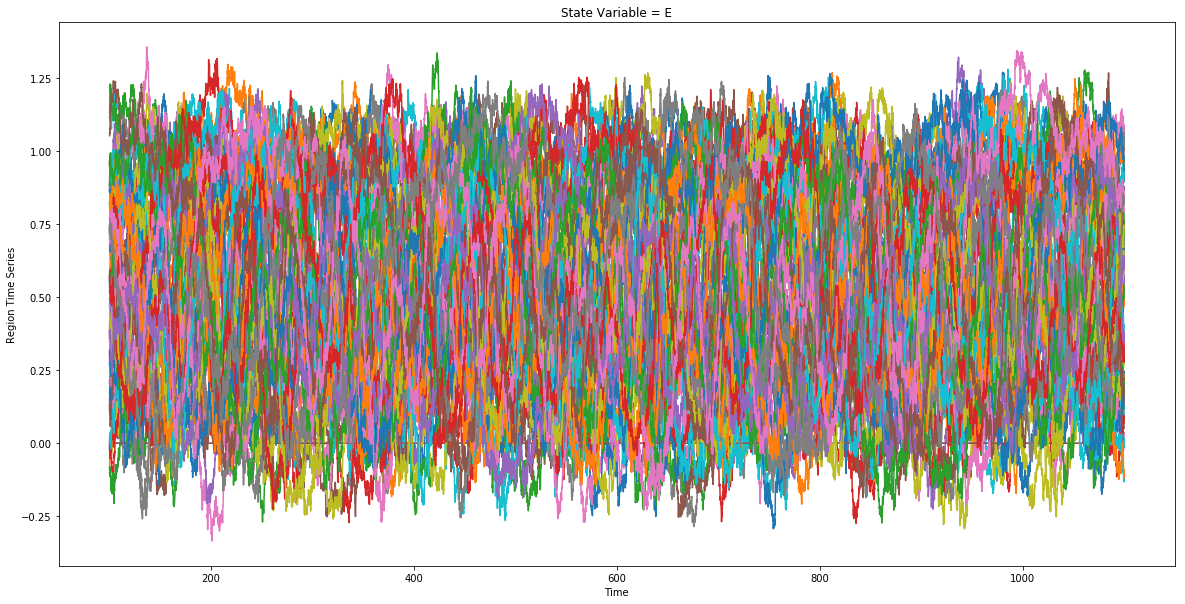

In [13]:
# Plot TVB time series
source_ts.plot_timeseries(plotter_config=plotter.config, per_variable=True, figsize=FIGSIZE, add_legend=False);

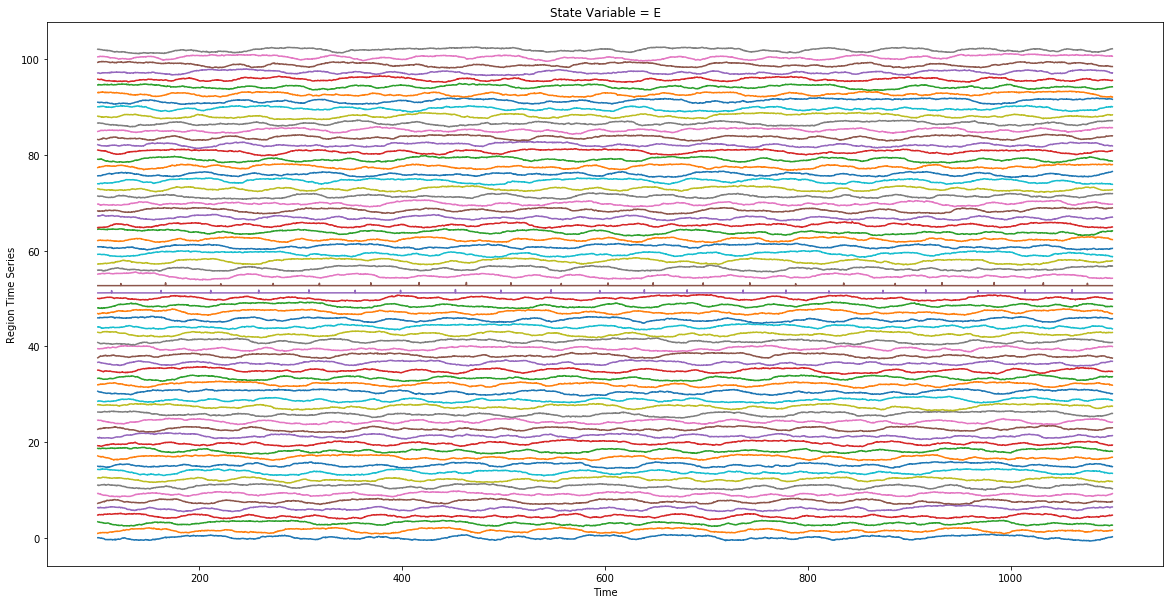

In [14]:
# TVB time series raster plot:
if source_ts.number_of_labels > 9:
    source_ts.plot_raster(plotter_config=plotter.config, per_variable=True, figsize=FIGSIZE, add_legend=False);

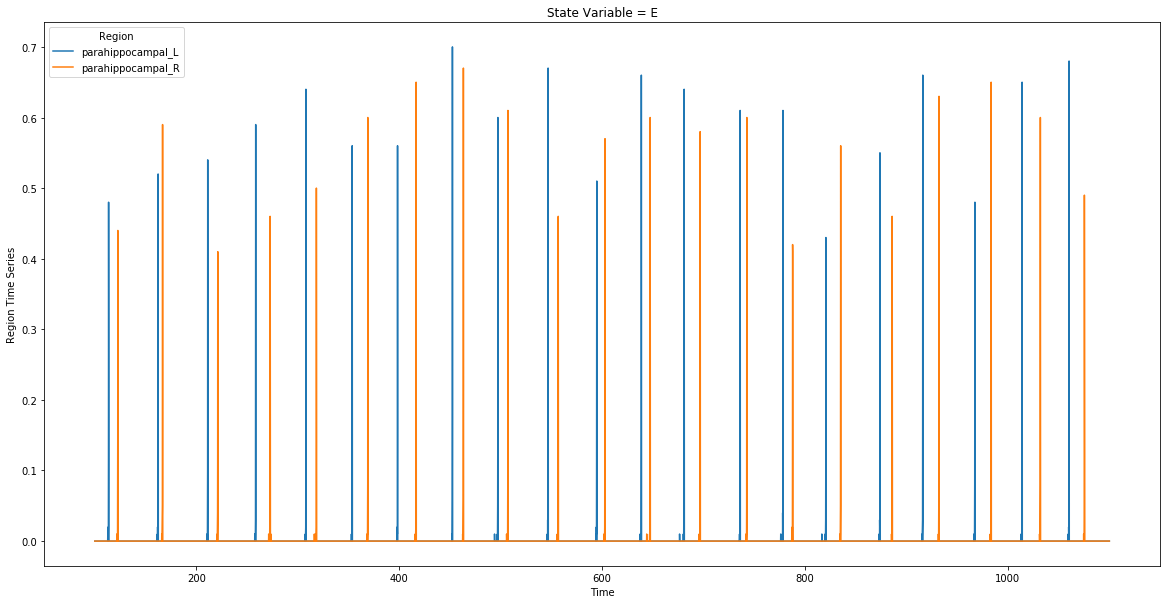

In [15]:
# Focus on the nodes modelled in NEST: 
n_spiking_nodes = len(simulator.tvb_spikeNet_interface.spiking_nodes_ids)
source_ts_nest = source_ts[:, :, simulator.tvb_spikeNet_interface.spiking_nodes_ids]
source_ts_nest.plot_timeseries(plotter_config=plotter.config, per_variable=True, figsize=FIGSIZE,
                               figname="Spiking nodes TVB Time Series");

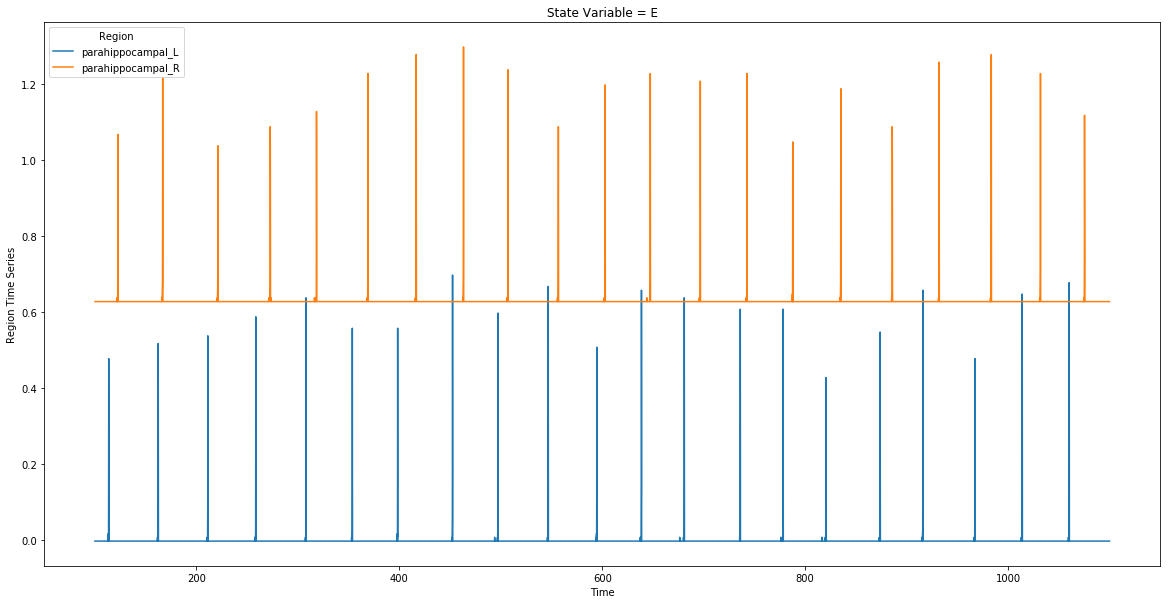

In [16]:
# Focus on the nodes modelled in NEST: raster plot
source_ts_nest.plot_raster(plotter_config=plotter.config, per_variable=True, figsize=FIGSIZE,
                           figname="Spiking nodes TVB Time Series Raster");

### Interactive time series plot

In [17]:
# # ...interactively as well
# # For interactive plotting:
# %matplotlib notebook 
# plotter.plot_timeseries_interactive(source_ts)

### Plot population mean membrane potential time series

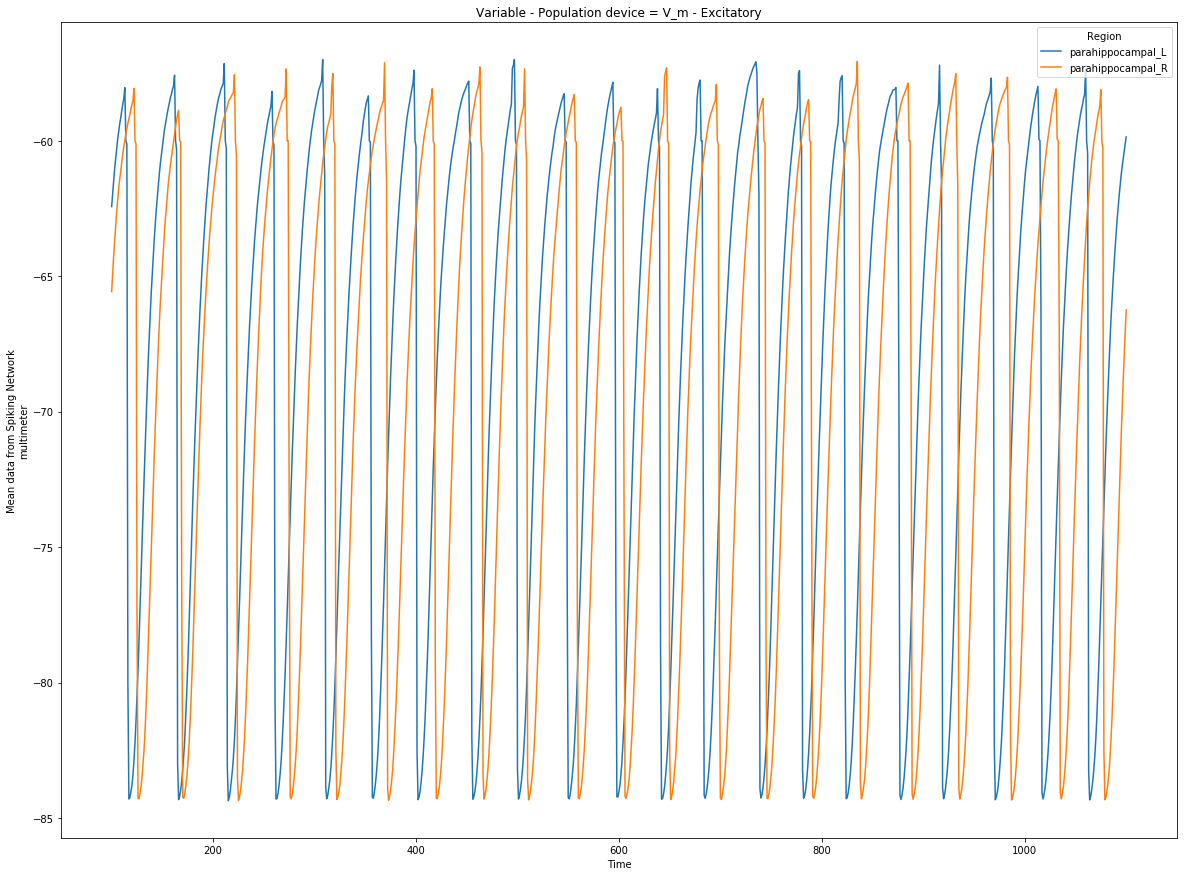

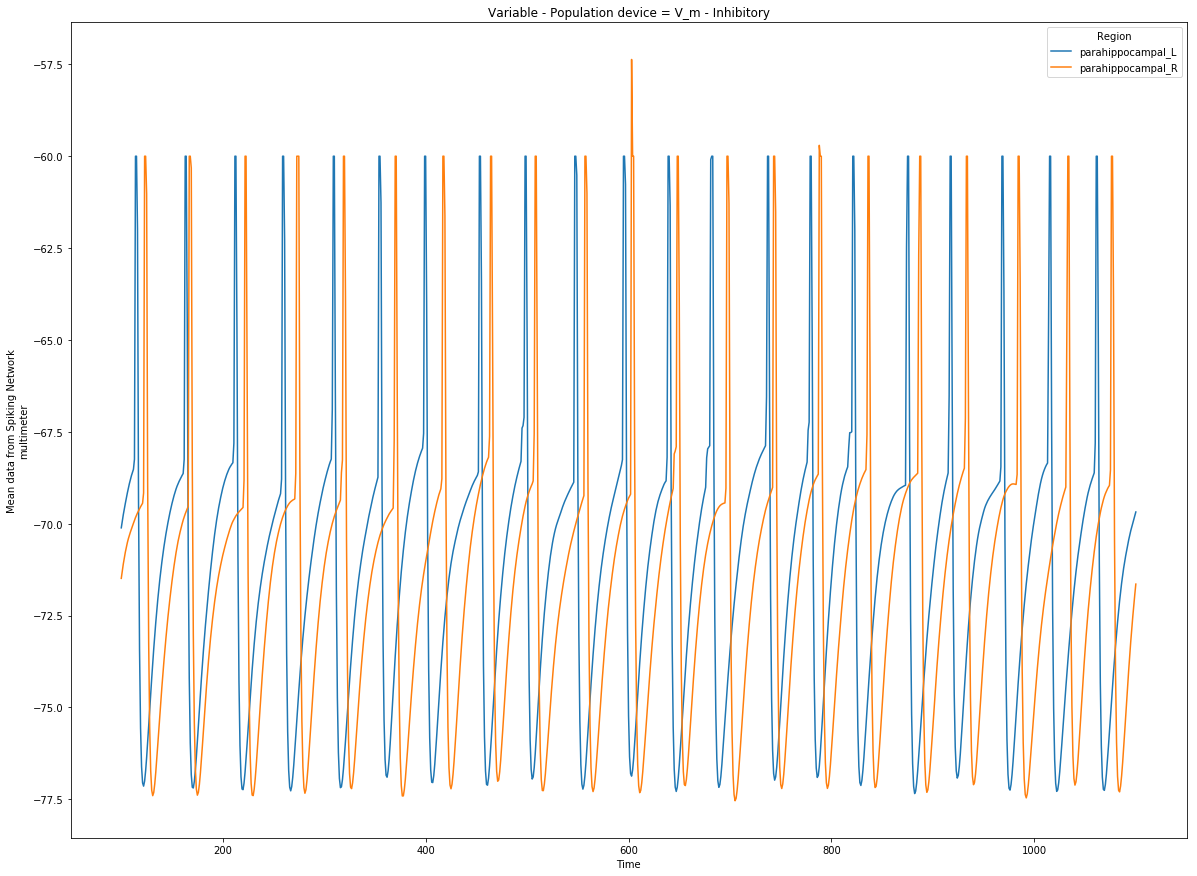

In [18]:
%matplotlib inline 
# Plot NEST multimeter variables
# Get continuous state variables from NEST via interfaces to NEST multimeter devices
# Get them directly as mean field quantities..
multimeter_mean_data = \
     TimeSeriesXarray(simulator.tvb_spikeNet_interface.get_mean_data_from_multimeter_to_TVBTimeSeries(),
                      connectivity=simulator.connectivity)
if transient:
    multimeter_mean_data = multimeter_mean_data[transient:]
if multimeter_mean_data is not None and multimeter_mean_data.size > 0:
     plotter.plot_multimeter_timeseries(multimeter_mean_data, plot_per_variable=True,
                                        time_series_class=TimeSeriesXarray, time_series_args={},
                                        var_pop_join_str=" - ", default_population_label="population",
                                        figname="NEST region time series");
if n_spiking_nodes > 3:
    plotter.plot_multimeter_raster(multimeter_mean_data, plot_per_variable=True,
                                   time_series_class=TimeSeriesXarray, time_series_args={},
                                   var_pop_join_str=" - ", default_population_label="population",
                                   figname="NEST region time series raster");


### Plot spikes' raster and mean spike rate for NEST regions

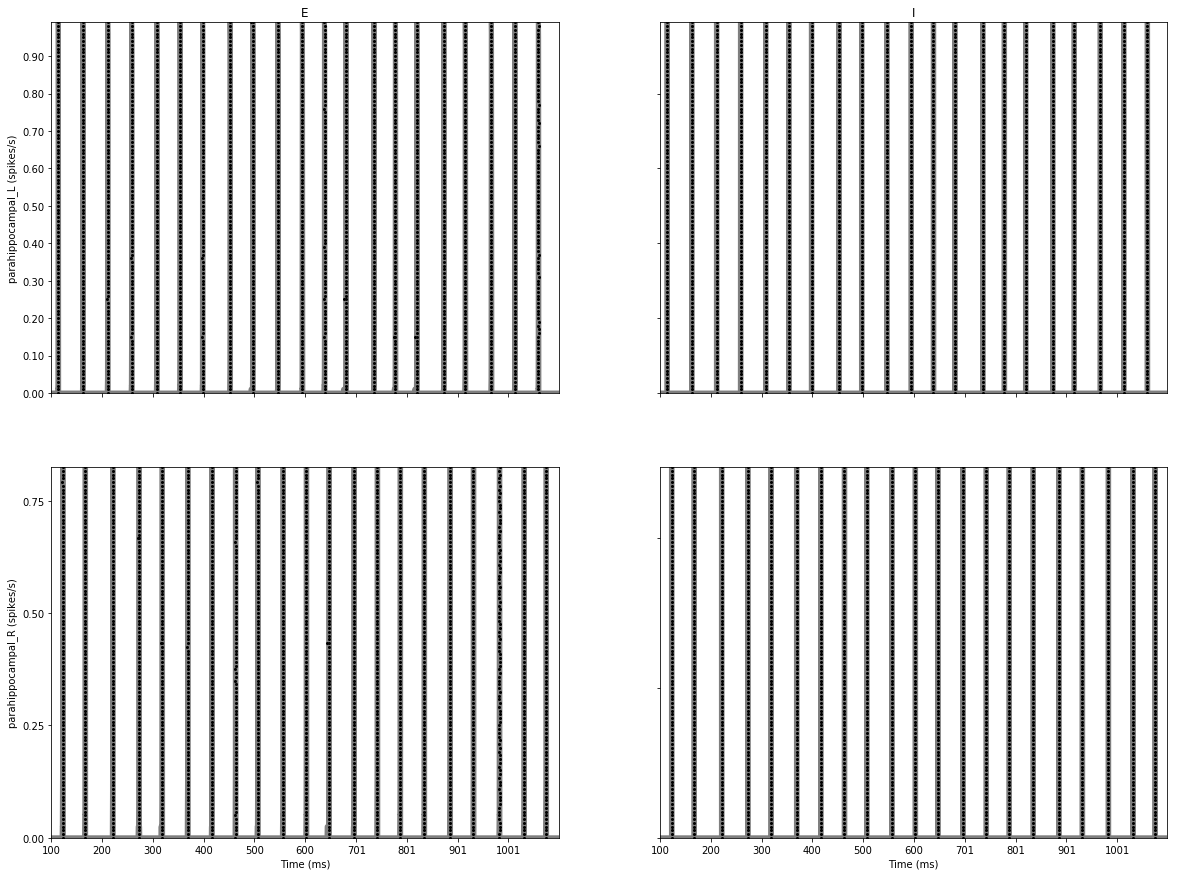

In [19]:
# Plot spikes and mean field spike rates time series
mf_rates_ts, spike_detectors = \
        simulator.tvb_spikeNet_interface.get_mean_spikes_rates_to_TVBTimeSeries(
            spikes_kernel_width=1.0,  # ms
            spikes_kernel_overlap=0.5, time=t)
if spike_detectors is not None and mf_rates_ts.size > 0:
    plotter.plot_spike_detectors(spike_detectors, rates=mf_rates_ts, title='Population spikes and mean spike rate');

### Get per neuron NEST time series and plot them, as well as mean quantities

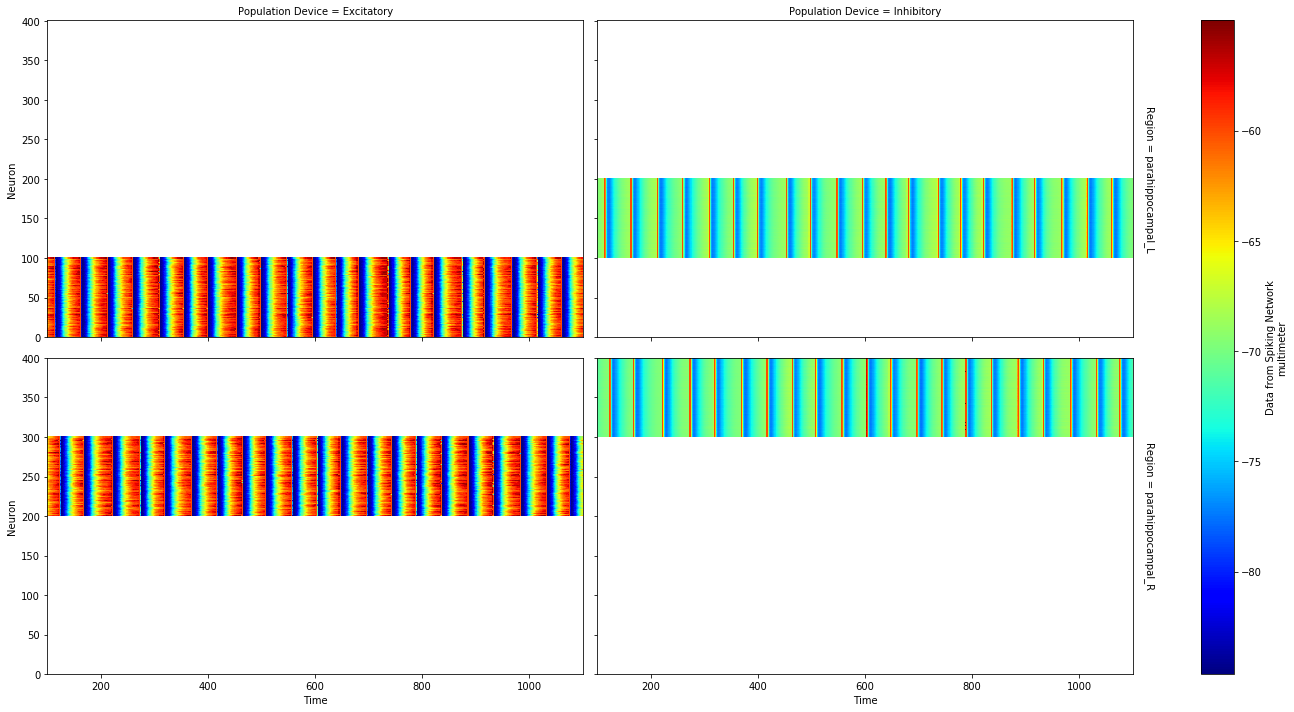

In [20]:
spiking_network = simulator.tvb_spikeNet_interface.spiking_network

# Time Series
nest_ts = spiking_network.get_data_from_multimeter(mode="per_neuron")
nest_ts = TimeSeriesXarray(nest_ts, connectivity=simulator.connectivity)
if transient:
    nest_ts = nest_ts[transient:]
if n_spiking_nodes <= 3:
    nest_ts.plot_map(y=nest_ts._data.dims[4], row=nest_ts._data.dims[2], col=nest_ts._data.dims[3],
                     per_variable=True,  cmap="jet", figsize=FIGSIZE, plotter_config=plotter.config);

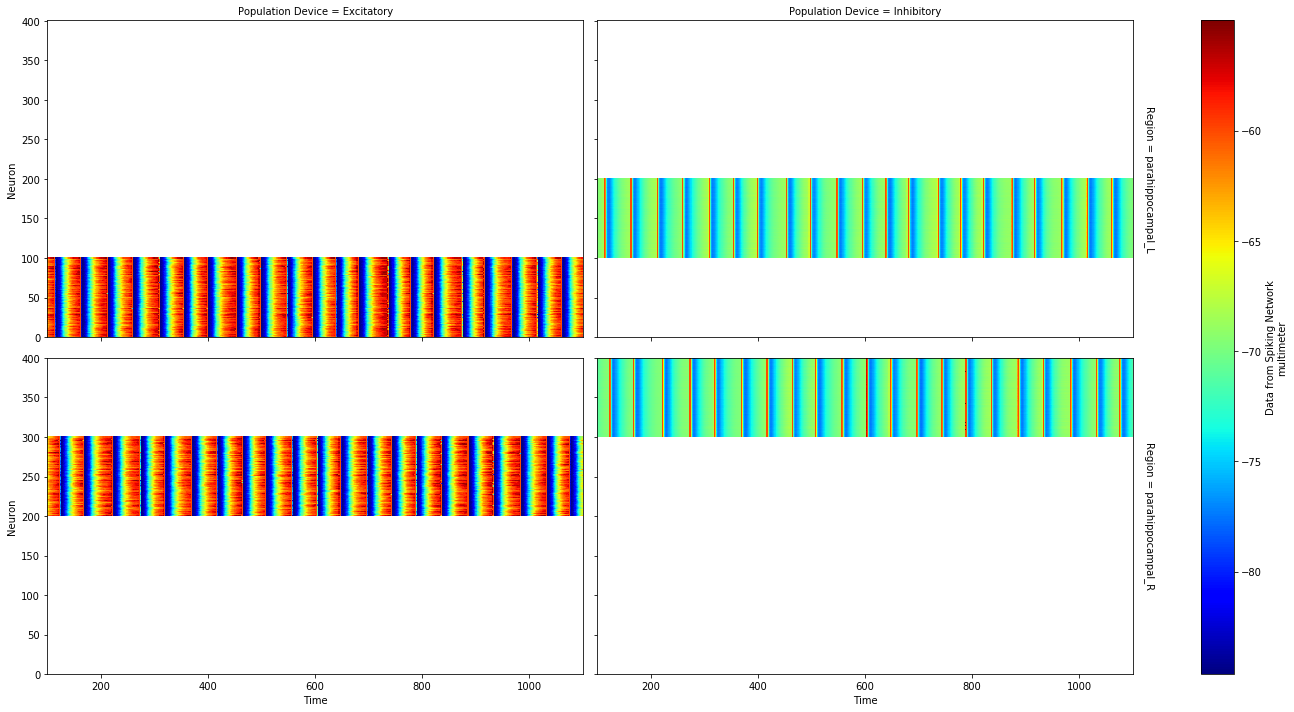

In [21]:
# Plot per neuron time series
nest_ts.plot_map(y=nest_ts._data.dims[4], row=nest_ts._data.dims[2], col=nest_ts._data.dims[3],
                 per_variable=True,  cmap="jet", figsize=FIGSIZE, plotter_config=plotter.config);

In [22]:
# Compute mean field
ts = TimeSeriesXarray(nest_ts._data.mean(axis=-1), connectivity=nest_ts.connectivity,
                      title="Mean field spiking nodes time series")
if writer:
    writer.write_tvb_to_h5(TimeSeriesRegion().from_xarray_DataArray(ts._data, connectivity=ts.connectivity),
                           os.path.join(config.out.FOLDER_RES, ts.title)+".h5", recursive=False)

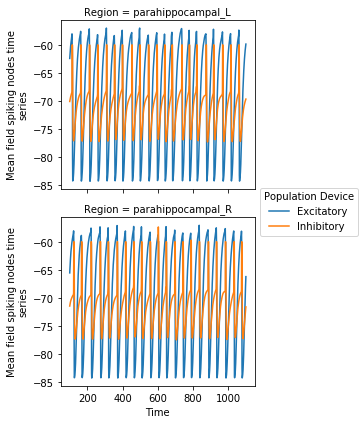

In [23]:
# Plot mean field
ts.plot_timeseries(plotter_config=plotter.config, per_variable=True)
if n_spiking_nodes > 3:
    ts.plot_raster(plotter_config=plotter.config, per_variable=True, linestyle="--", alpha=0.5, linewidth=0.5);

In [24]:
from xarray import DataArray

# Spikes
nest_spikes = spiking_network.get_spikes(mode="events", return_type="Series", exclude_times=exclude_times)
if writer:
    writer.write_object(nest_spikes.to_dict(), path=os.path.join(config.out.FOLDER_RES,  "NEST_Spikes") + ".h5")

# Compute mean spike rates
spike_rates = []
pop_labels = []
population_sizes = [N_E, N_I]
duration = (t[-1] - t[0]) / 1000  # in sec
for i_pop, (pop_label, pop_spikes) in enumerate(nest_spikes.iteritems()):
    pop_labels.append(pop_label)
    spike_rates.append([])
    reg_labels = []
    for reg_label, reg_spikes in pop_spikes.iteritems():
        reg_labels.append(reg_label)
        # rates (spikes/sec) =
        #   total_number_of_spikes (int) / total_time_duration (sec) / total_number_of_neurons_in_pop (int)
        spike_rates[-1].append(len(reg_spikes["times"]) / duration / population_sizes[i_pop])

spike_rates = DataArray(np.array(spike_rates), dims=["Population", "Region"], name="NEST_spike_rates",
                        coords={"Population": pop_labels, "Region": reg_labels})
print(spike_rates)
if writer:
    writer.write_object(spike_rates.to_dict(), path=os.path.join(config.out.FOLDER_RES, spike_rates.name) + ".h5")

<xarray.DataArray 'NEST_spike_rates' (Population: 2, Region: 2)>
array([[21.04, 21.03],
       [21.  , 21.  ]])
Coordinates:
  * Population  (Population) <U1 'E' 'I'
  * Region      (Region) <U17 'parahippocampal_L' 'parahippocampal_R'


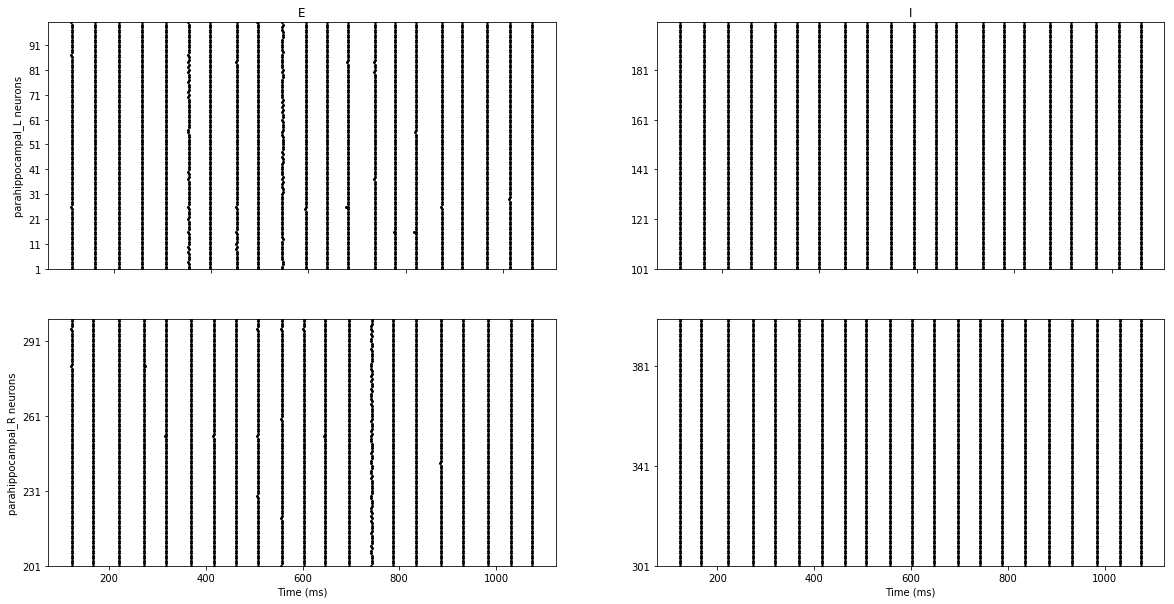

In [25]:
# Plot spikes
plotter.plot_spike_events(nest_spikes, figsize=FIGSIZE);

# References

1 Paula Sanz Leon, Stuart A. Knock, M. Marmaduke Woodman, Lia Domide, <br>
  Jochen Mersmann, Anthony R. McIntosh, Viktor Jirsa (2013) <br>
  The Virtual Brain: a simulator of primate brain network dynamics. <br>
  Frontiers in Neuroinformatics (7:10. doi: 10.3389/fninf.2013.00010) <br>
  https://www.thevirtualbrain.org/tvb/zwei <br>
  https://github.com/the-virtual-brain <br>

2 Ritter P, Schirner M, McIntosh AR, Jirsa VK. 2013.  <br>
  The Virtual Brain integrates computational modeling  <br>
  and multimodal neuroimaging. Brain Connectivity 3:121–145. <br>

3 Jordan, Jakob; Mørk, Håkon; Vennemo, Stine Brekke;   Terhorst, Dennis; Peyser, <br>
  Alexander; Ippen, Tammo; Deepu, Rajalekshmi;   Eppler, Jochen Martin; <br>
  van Meegen, Alexander;   Kunkel, Susanne; Sinha, Ankur; Fardet, Tanguy; Diaz, <br>
  Sandra; Morrison, Abigail; Schenck, Wolfram; Dahmen, David;   Pronold, Jari; <br>
  Stapmanns, Jonas;   Trensch, Guido; Spreizer, Sebastian;   Mitchell, Jessica; <br>
  Graber, Steffen; Senk, Johanna; Linssen, Charl; Hahne, Jan; Serenko, Alexey; <br>
  Naoumenko, Daniel; Thomson, Eric;   Kitayama, Itaru; Berns, Sebastian;   <br>
  Plesser, Hans Ekkehard <br>
  NEST is a simulator for spiking neural network models that focuses <br>
  on the dynamics, size and structure of neural systems rather than on <br>
  the exact morphology of individual neurons. <br>
  For further information, visit http://www.nest-simulator.org. <br>
  The release notes for this release are available at  <br>
  https://github.com/nest/nest-simulator/releases/tag/v2.18.0 <br>